In [1]:
%load_ext autoreload
%autoreload 2

In [129]:
from collections import defaultdict
import itertools
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis import analogy, analogy_pseudocausal
from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory, flatten_trajectory
from src.datasets.speech_equivalence import SpeechHiddenStateDataset
from src.analysis.ngram_decoding import NgramDecoder


In [3]:
torch.set_num_threads(8)

In [4]:
base_model = "w2v2_pc_8"

model_class = "ffff_32-pc-mAP1"#discrim-rnn_32-pc-mAP1"
model_name = "word_broad_10frames_fixedlen25"

train_dataset = "librispeech-train-clean-100"
# hidden_states_path = f"outputs/hidden_states/{base_model}/{train_dataset}.h5"
hidden_states_path = f"/scratch/jgauthier/{base_model}_{train_dataset}.h5"
state_space_specs_path = f"outputs/analogy/inputs/{train_dataset}/w2v2_pc/state_space_spec.h5"
embeddings_path = f"outputs/model_embeddings/{train_dataset}/{base_model}/{model_class}/{model_name}/{train_dataset}.npy"

output_dir = f"."

pos_counts_path = "data/pos_counts.pkl"

seed = 42

metric = "cosine"

agg_fns = [
    ("mean_within_cut", "phoneme")
]

In [5]:
if embeddings_path == "ID":
    model_representations = SpeechHiddenStateDataset.from_hdf5(hidden_states_path).states
else:
    with open(embeddings_path, "rb") as f:
        model_representations: np.ndarray = np.load(f)
state_space_spec = StateSpaceAnalysisSpec.from_hdf5(state_space_specs_path)
assert state_space_spec.is_compatible_with(model_representations)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'labels_are_repr' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


## Prepare ngram labels

In [6]:
from src.analysis.state_space import LabeledStateTrajectory

In [7]:
lst = LabeledStateTrajectory.from_embeddings(model_representations, state_space_spec)

Preparing metadata:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
frame_metadata = lst.metadata
frame_metadata["phoneme_boundary"] = frame_metadata.phoneme_onset_frame_idx != frame_metadata.phoneme_onset_frame_idx.shift(1)
frame_metadata["phoneme_boundary_idx"] = frame_metadata.phoneme_boundary.cumsum()
frame_metadata.head(10)

,phoneme_onset_frame_idx,phoneme_idx,phoneme_label,label,instance_idx,span_onset_frame_idx,span_offset_frame_idx,syllable_onset_frame_idx,syllable_idx,syllable_label,label_idx,relative_frame_idx,phoneme_boundary,phoneme_boundary_idx
frame_idx,,,,,,,,,,,,,,
10,10,0,D,dying,0,10,32,10,0,"(D, AY)",0,0,True,1
11,10,0,D,dying,0,10,32,10,0,"(D, AY)",0,1,False,1
12,10,0,D,dying,0,10,32,10,0,"(D, AY)",0,2,False,1
13,10,0,D,dying,0,10,32,10,0,"(D, AY)",0,3,False,1
14,10,0,D,dying,0,10,32,10,0,"(D, AY)",0,4,False,1
15,15,1,AY,dying,0,10,32,10,0,"(D, AY)",0,5,True,2
16,15,1,AY,dying,0,10,32,10,0,"(D, AY)",0,6,False,2
17,15,1,AY,dying,0,10,32,10,0,"(D, AY)",0,7,False,2
18,15,1,AY,dying,0,10,32,10,0,"(D, AY)",0,8,False,2


In [9]:
phoneme_info = frame_metadata.groupby("phoneme_boundary_idx").first()[["phoneme_label"]]
phoneme_info["phoneme_p-1_label"] = phoneme_info.phoneme_label.shift(1)
phoneme_info["phoneme_p-2_label"] = phoneme_info.phoneme_label.shift(2)
phoneme_info["phoneme_p+1_label"] = phoneme_info.phoneme_label.shift(-1)
phoneme_info["phoneme_p+2_label"] = phoneme_info.phoneme_label.shift(-2)
phoneme_info = phoneme_info[["phoneme_p-2_label", "phoneme_p-1_label", "phoneme_label", "phoneme_p+1_label", "phoneme_p+2_label"]]

In [10]:
frame_metadata = frame_metadata.merge(phoneme_info.drop(columns=["phoneme_label"]),
                                      left_on="phoneme_boundary_idx", right_index=True)

In [164]:
frame_metadata["backward_trigram"] = frame_metadata[["phoneme_p-2_label", "phoneme_p-1_label", "phoneme_label"]].fillna("NA").agg(lambda x: "_".join(x), axis=1)
frame_metadata["backward_bigram"] = frame_metadata[["phoneme_p-1_label", "phoneme_label"]].fillna("NA").agg(lambda x: "_".join(x), axis=1)
frame_metadata["forward_trigram"] = frame_metadata[["phoneme_label", "phoneme_p+1_label", "phoneme_p+2_label"]].fillna("NA").agg(lambda x: "_".join(x), axis=1)
frame_metadata["forward_bigram"] = frame_metadata[["phoneme_label", "phoneme_p+1_label"]].fillna("NA").agg(lambda x: "_".join(x), axis=1)

In [12]:
frame_metadata["relative_frame_idx_from_span_offset"] = frame_metadata.span_offset_frame_idx - frame_metadata.span_onset_frame_idx - frame_metadata.relative_frame_idx

## Learn classifier

In [ ]:
device = "cuda:2"

### Backward trigram

In [144]:
dec = NgramDecoder(lst, device)
dec.prepare_dataset(frame_metadata, "backward_trigram")

Number of classes: 9983


/userdata/jgauthier/projects/ideal-word-representations/src/analysis/ngram_decoding.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame_metadata["class_idx"] = self.frame_metadata[class_key].map(self.class_to_idx)
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/ngram_decoding.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame_metadata["class_idx"] = self.frame_metadata[class_key].map(self.class_to_idx)
/userdata/jgauthier/projects/ideal-word-representations/src/

In [145]:
dec.prime()

In [146]:
dec.train()

Iteration 0, Training Loss: 9.200100898742676


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 0, Validation Loss: 9.220589117570357
Iteration 500, Training Loss: 9.129716873168945


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 500, Validation Loss: 8.973803028915867
Iteration 1000, Training Loss: 8.188949584960938


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 1000, Validation Loss: 8.315296057498816
Iteration 1500, Training Loss: 8.012601852416992


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 1500, Validation Loss: 7.800786769751347
Iteration 2000, Training Loss: 7.134275913238525


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 2000, Validation Loss: 7.393767197926839
Iteration 2500, Training Loss: 7.164877891540527


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 2500, Validation Loss: 7.084416562860662
Iteration 3000, Training Loss: 7.096572399139404


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 3000, Validation Loss: 6.815061843756474
Iteration 3500, Training Loss: 6.693850994110107


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 3500, Validation Loss: 6.599452799016779
Iteration 4000, Training Loss: 6.072360038757324


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 4000, Validation Loss: 6.416245171518037
Iteration 4500, Training Loss: 6.409924507141113


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 4500, Validation Loss: 6.256015199603456
Iteration 5000, Training Loss: 5.995366096496582


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 5000, Validation Loss: 6.124158440214215
Iteration 5500, Training Loss: 5.761220932006836


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 5500, Validation Loss: 5.996764746579257
Iteration 6000, Training Loss: 6.099676132202148


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 6000, Validation Loss: 5.886099338531494
Iteration 6500, Training Loss: 5.9917073249816895


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 6500, Validation Loss: 5.794524814143325
Iteration 7000, Training Loss: 5.2819318771362305


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 7000, Validation Loss: 5.7173450209877705
Iteration 7500, Training Loss: 4.942273139953613


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 7500, Validation Loss: 5.642329273801861
Iteration 8000, Training Loss: 5.286633014678955


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 8000, Validation Loss: 5.576954046885173
Iteration 8500, Training Loss: 5.693724632263184


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 8500, Validation Loss: 5.509425683455034
Iteration 9000, Training Loss: 5.553866386413574


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 9000, Validation Loss: 5.452616070256089
Iteration 9500, Training Loss: 5.405208110809326


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 9500, Validation Loss: 5.396901954304088
Iteration 10000, Training Loss: 5.720990180969238


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 10000, Validation Loss: 5.3644491108981045
Iteration 10500, Training Loss: 5.0006818771362305


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 10500, Validation Loss: 5.329668189540054
Iteration 11000, Training Loss: 5.280819892883301


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 11000, Validation Loss: 5.283086068702467
Iteration 11500, Training Loss: 5.095205307006836


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 11500, Validation Loss: 5.249394936995073
Iteration 12000, Training Loss: 5.2230753898620605


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 12000, Validation Loss: 5.215016943035704
Iteration 12500, Training Loss: 5.087889194488525


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 12500, Validation Loss: 5.183458703936952
Iteration 13000, Training Loss: 6.098841667175293


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 13000, Validation Loss: 5.153911344932787
Iteration 13500, Training Loss: 5.173586368560791


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 13500, Validation Loss: 5.132450768441865
Iteration 14000, Training Loss: 5.3057169914245605


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 14000, Validation Loss: 5.115370056845925
Iteration 14500, Training Loss: 4.134236812591553


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 14500, Validation Loss: 5.086852102568655
Iteration 15000, Training Loss: 5.165999412536621


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 15000, Validation Loss: 5.073141473712343
Iteration 15500, Training Loss: 4.944223880767822


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 15500, Validation Loss: 5.05071244095311
Iteration 16000, Training Loss: 5.350221157073975


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 16000, Validation Loss: 5.024363113172127
Iteration 16500, Training Loss: 5.512909889221191


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 16500, Validation Loss: 5.006327282298695
Iteration 17000, Training Loss: 5.438843727111816


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 17000, Validation Loss: 4.988306334524443
Iteration 17500, Training Loss: 5.547845363616943


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 17500, Validation Loss: 4.9788240952925245
Iteration 18000, Training Loss: 5.0199971199035645


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 18000, Validation Loss: 4.9662479631828536
Iteration 18500, Training Loss: 4.642054557800293


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 18500, Validation Loss: 4.953630331790809
Iteration 19000, Training Loss: 4.404332637786865


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 19000, Validation Loss: 4.929528539830988
Iteration 19500, Training Loss: 4.401410102844238


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 19500, Validation Loss: 4.9237807736252295
Iteration 20000, Training Loss: 4.528767108917236


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 20000, Validation Loss: 4.908486958706018
Iteration 20500, Training Loss: 4.523669242858887


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 20500, Validation Loss: 4.900876912203702
Iteration 21000, Training Loss: 5.047328472137451


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 21000, Validation Loss: 4.891100883483887
Iteration 21500, Training Loss: 5.030864238739014


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 21500, Validation Loss: 4.882442893403949
Iteration 22000, Training Loss: 5.316448211669922


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 22000, Validation Loss: 4.8711901289044
Iteration 22500, Training Loss: 4.42431640625


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 22500, Validation Loss: 4.861724188833525
Iteration 23000, Training Loss: 5.459365367889404


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 23000, Validation Loss: 4.855928464369341
Iteration 23500, Training Loss: 5.607192039489746


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 23500, Validation Loss: 4.844457077257561
Iteration 24000, Training Loss: 4.342946529388428


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 24000, Validation Loss: 4.82988792477232
Iteration 24500, Training Loss: 4.637324810028076


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 24500, Validation Loss: 4.823649550929214
Iteration 25000, Training Loss: 4.945323467254639


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 25000, Validation Loss: 4.813259009158973
Iteration 25500, Training Loss: 4.362917423248291


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 25500, Validation Loss: 4.8041026664502695
Iteration 26000, Training Loss: 3.704042673110962


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 26000, Validation Loss: 4.800827084165631
Iteration 26500, Training Loss: 4.382824897766113


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 26500, Validation Loss: 4.788476062543465
Iteration 27000, Training Loss: 4.446725845336914


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 27000, Validation Loss: 4.785421385909572
Iteration 27500, Training Loss: 4.653563499450684


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 27500, Validation Loss: 4.782045190984553
Iteration 28000, Training Loss: 4.3927412033081055


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 28000, Validation Loss: 4.7762955752286045
Iteration 28500, Training Loss: 4.632218360900879


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 28500, Validation Loss: 4.773185137546424
Iteration 29000, Training Loss: 4.56321907043457


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 29000, Validation Loss: 4.768647714094683
Iteration 29500, Training Loss: 4.774965763092041


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 29500, Validation Loss: 4.76137536944765
Iteration 30000, Training Loss: 5.116981506347656


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 30000, Validation Loss: 4.758920163819284
Iteration 30500, Training Loss: 4.1566901206970215


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 30500, Validation Loss: 4.748171112754128
Iteration 31000, Training Loss: 4.609310150146484


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 31000, Validation Loss: 4.737195087201668
Iteration 31500, Training Loss: 5.185815811157227


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 31500, Validation Loss: 4.736351186578924
Iteration 32000, Training Loss: 4.946315765380859


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 32000, Validation Loss: 4.727484659715132
Iteration 32500, Training Loss: 4.771023273468018


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 32500, Validation Loss: 4.727082165804776
Iteration 33000, Training Loss: 4.948067665100098


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 33000, Validation Loss: 4.726094563802083
Iteration 33500, Training Loss: 3.9322402477264404


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 33500, Validation Loss: 4.719643231594201
Iteration 34000, Training Loss: 4.863470077514648


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 34000, Validation Loss: 4.718147798018022
Iteration 34500, Training Loss: 4.770181179046631


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 34500, Validation Loss: 4.707624666618578
Iteration 35000, Training Loss: 4.861806869506836


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 35000, Validation Loss: 4.704740524291992
Iteration 35500, Training Loss: 4.204247951507568


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 35500, Validation Loss: 4.700485128344911
Iteration 36000, Training Loss: 4.597332000732422


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 36000, Validation Loss: 4.698286894595984
Iteration 36500, Training Loss: 5.180706977844238


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 36500, Validation Loss: 4.699958237734708
Iteration 37000, Training Loss: 4.521508693695068


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 37000, Validation Loss: 4.692256190560081
Iteration 37500, Training Loss: 4.249864101409912


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 37500, Validation Loss: 4.69244824033795
Iteration 38000, Training Loss: 4.2811279296875


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 38000, Validation Loss: 4.680469599637118
Iteration 38500, Training Loss: 5.0912017822265625


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 38500, Validation Loss: 4.678084257877234
Iteration 39000, Training Loss: 5.097963809967041


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 39000, Validation Loss: 4.679066845864961
Iteration 39500, Training Loss: 4.8929877281188965


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 39500, Validation Loss: 4.674705317526152
Iteration 40000, Training Loss: 4.46549654006958


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 40000, Validation Loss: 4.665416515234745
Iteration 40500, Training Loss: 4.970424175262451


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 40500, Validation Loss: 4.65948029720422
Iteration 41000, Training Loss: 4.511471748352051


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 41000, Validation Loss: 4.662339326107141
Iteration 41500, Training Loss: 5.161144256591797


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 41500, Validation Loss: 4.66659486655033
Iteration 42000, Training Loss: 5.011571407318115


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 42000, Validation Loss: 4.6641380281159375
Early stopping


In [147]:
test_df_bwd = dec.predict()

Testing:   0%|          | 0/1058 [00:00<?, ?it/s]

In [148]:
test_df_bwd = pd.merge(test_df_bwd,
                   (test_df_bwd.groupby(["label", "instance_idx"]).phoneme_idx.max() + 1).rename("word_length"),
                   left_on=["label", "instance_idx"],
                   right_index=True)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

<Axes: xlabel='phoneme_idx', ylabel='correct'>

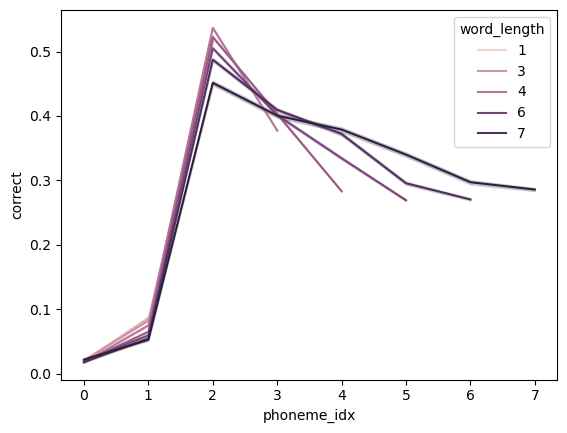

In [150]:
sns.lineplot(data=test_df_bwd[test_df_bwd.word_length <= 8], x="phoneme_idx", y="correct", hue="word_length",
             errorbar="se")

<Axes: xlabel='phoneme_idx', ylabel='correct'>

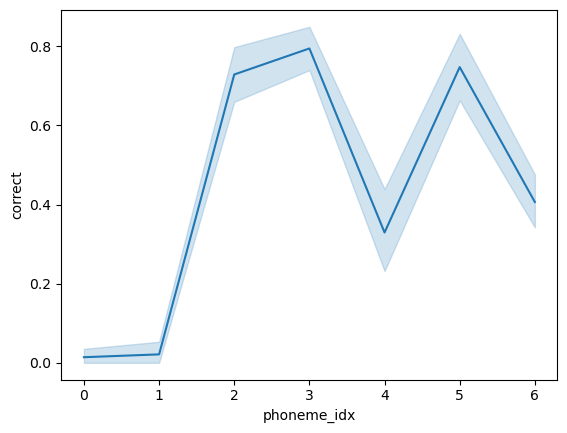

In [161]:
sns.lineplot(data=test_df_bwd[test_df_bwd.label == "society"],
             x="phoneme_idx", y="correct")

In [160]:
test_df_bwd[test_df_bwd.word_length > 5].label.value_counts().head(20)

label
circumstances    1334
conversation     1252
situation        1098
experience       1052
impossible       1007
society           980
understand        978
imagination       963
necessary         958
considerable      940
happiness         936
entirely          925
expected          907
expression        889
companions        885
satisfied         884
darkness          879
afterwards        878
immediately       878
curiosity         872
Name: count, dtype: int64

### Forward trigram

In [137]:
dec_fwd = NgramDecoder(lst, device)
dec_fwd.prepare_dataset(frame_metadata, "forward_trigram")
dec_fwd.prime()

Number of classes: 10338


/userdata/jgauthier/projects/ideal-word-representations/src/analysis/ngram_decoding.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame_metadata["class_idx"] = self.frame_metadata[class_key].map(self.class_to_idx)
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/ngram_decoding.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame_metadata["class_idx"] = self.frame_metadata[class_key].map(self.class_to_idx)
/userdata/jgauthier/projects/ideal-word-representations/src/

In [138]:
dec_fwd.train()

Iteration 0, Training Loss: 9.237963676452637


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 0, Validation Loss: 9.256052913087787
Iteration 500, Training Loss: 9.1661958694458


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 500, Validation Loss: 9.24715634548303
Iteration 1000, Training Loss: 8.517247200012207


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 1000, Validation Loss: 8.793294819918545
Iteration 1500, Training Loss: 8.581366539001465


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 1500, Validation Loss: 8.424121220906576
Iteration 2000, Training Loss: 8.32391357421875


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 2000, Validation Loss: 8.13476614518599
Iteration 2500, Training Loss: 7.847609519958496


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 2500, Validation Loss: 7.906842723037258
Iteration 3000, Training Loss: 7.706791877746582


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 3000, Validation Loss: 7.72493466463956
Iteration 3500, Training Loss: 7.7023115158081055


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 3500, Validation Loss: 7.564726627234257
Iteration 4000, Training Loss: 7.167840957641602


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 4000, Validation Loss: 7.424105557528409
Iteration 4500, Training Loss: 7.129507064819336


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 4500, Validation Loss: 7.30836196379228
Iteration 5000, Training Loss: 7.707582473754883


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 5000, Validation Loss: 7.213082472483317
Iteration 5500, Training Loss: 6.645970821380615


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 5500, Validation Loss: 7.119090354803837
Iteration 6000, Training Loss: 6.853459358215332


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 6000, Validation Loss: 7.04462227676854
Iteration 6500, Training Loss: 6.903408527374268


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 6500, Validation Loss: 6.97646393920436
Iteration 7000, Training Loss: 6.82916784286499


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 7000, Validation Loss: 6.9121222929521045
Iteration 7500, Training Loss: 6.884300708770752


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 7500, Validation Loss: 6.851496132937345
Iteration 8000, Training Loss: 6.577840805053711


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 8000, Validation Loss: 6.799685304815119
Iteration 8500, Training Loss: 7.100055694580078


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 8500, Validation Loss: 6.748962387894139
Iteration 9000, Training Loss: 6.672268867492676


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 9000, Validation Loss: 6.711228023875844
Iteration 9500, Training Loss: 6.689623832702637


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 9500, Validation Loss: 6.676632115335176
Iteration 10000, Training Loss: 6.884146213531494


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 10000, Validation Loss: 6.647642843651049
Iteration 10500, Training Loss: 6.798595428466797


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 10500, Validation Loss: 6.612183310768821
Iteration 11000, Training Loss: 6.425135135650635


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 11000, Validation Loss: 6.589197115464644
Iteration 11500, Training Loss: 6.242987632751465


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 11500, Validation Loss: 6.5615809614008125
Iteration 12000, Training Loss: 6.403153419494629


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 12000, Validation Loss: 6.542537645860151
Iteration 12500, Training Loss: 6.391845703125


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 12500, Validation Loss: 6.520847421703917
Iteration 13000, Training Loss: 6.732174396514893


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 13000, Validation Loss: 6.495418360739043
Iteration 13500, Training Loss: 6.536129951477051


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 13500, Validation Loss: 6.477704091505571
Iteration 14000, Training Loss: 6.782217979431152


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 14000, Validation Loss: 6.463773915261934
Iteration 14500, Training Loss: 6.383464813232422


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 14500, Validation Loss: 6.439513553272594
Iteration 15000, Training Loss: 5.983537673950195


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 15000, Validation Loss: 6.421126943646056
Iteration 15500, Training Loss: 6.400078773498535


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 15500, Validation Loss: 6.409887747331099
Iteration 16000, Training Loss: 6.992994785308838


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 16000, Validation Loss: 6.400287324732
Iteration 16500, Training Loss: 6.611201763153076


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 16500, Validation Loss: 6.382004073171904
Iteration 17000, Training Loss: 5.760940074920654


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 17000, Validation Loss: 6.369558478846694
Iteration 17500, Training Loss: 6.558719158172607


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 17500, Validation Loss: 6.356855797045158
Iteration 18000, Training Loss: 6.451787948608398


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 18000, Validation Loss: 6.341654300689697
Iteration 18500, Training Loss: 6.2812066078186035


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 18500, Validation Loss: 6.331735408667362
Iteration 19000, Training Loss: 6.141944408416748


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 19000, Validation Loss: 6.323387117096872
Iteration 19500, Training Loss: 5.85728120803833


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 19500, Validation Loss: 6.310632517843535
Iteration 20000, Training Loss: 6.320214748382568


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 20000, Validation Loss: 6.3051135323264385
Iteration 20500, Training Loss: 6.5408124923706055


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 20500, Validation Loss: 6.289317145492092
Iteration 21000, Training Loss: 6.1306610107421875


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 21000, Validation Loss: 6.275042042587742
Iteration 21500, Training Loss: 6.469917297363281


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 21500, Validation Loss: 6.274199601375695
Iteration 22000, Training Loss: 6.648998737335205


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 22000, Validation Loss: 6.263578169273607
Iteration 22500, Training Loss: 6.1352739334106445


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 22500, Validation Loss: 6.257292790846392
Iteration 23000, Training Loss: 5.810963153839111


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 23000, Validation Loss: 6.247872482646596
Iteration 23500, Training Loss: 6.527712345123291


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 23500, Validation Loss: 6.23839570536758
Iteration 24000, Training Loss: 6.0993757247924805


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 24000, Validation Loss: 6.232625036528616
Iteration 24500, Training Loss: 6.330202579498291


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 24500, Validation Loss: 6.230603897210323
Iteration 25000, Training Loss: 6.196374893188477


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 25000, Validation Loss: 6.2224109389565205
Iteration 25500, Training Loss: 5.993272304534912


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 25500, Validation Loss: 6.21670997504032
Iteration 26000, Training Loss: 5.963375091552734


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 26000, Validation Loss: 6.210661815874504
Iteration 26500, Training Loss: 6.858214855194092


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 26500, Validation Loss: 6.207128929369377
Iteration 27000, Training Loss: 6.585414886474609


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 27000, Validation Loss: 6.201482873974425
Iteration 27500, Training Loss: 6.436379909515381


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 27500, Validation Loss: 6.1917754231077256
Iteration 28000, Training Loss: 6.8739728927612305


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 28000, Validation Loss: 6.188014203851873
Iteration 28500, Training Loss: 6.150717258453369


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 28500, Validation Loss: 6.186454816298052
Iteration 29000, Training Loss: 6.269533634185791


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 29000, Validation Loss: 6.182532064842455
Iteration 29500, Training Loss: 6.420442581176758


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 29500, Validation Loss: 6.17891297195897
Iteration 30000, Training Loss: 5.961025238037109


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 30000, Validation Loss: 6.175430008859346
Iteration 30500, Training Loss: 6.796784400939941


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 30500, Validation Loss: 6.1719889640808105
Iteration 31000, Training Loss: 6.375732421875


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 31000, Validation Loss: 6.167886184923576
Iteration 31500, Training Loss: 5.998137950897217


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 31500, Validation Loss: 6.162822174303459
Iteration 32000, Training Loss: 6.269290447235107


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 32000, Validation Loss: 6.164025537895434
Iteration 32500, Training Loss: 6.1219353675842285


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 32500, Validation Loss: 6.152568860487505
Iteration 33000, Training Loss: 5.935788154602051


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 33000, Validation Loss: 6.152128132906827
Iteration 33500, Training Loss: 6.524031639099121


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 33500, Validation Loss: 6.1472884091463955
Iteration 34000, Training Loss: 6.694777011871338


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 34000, Validation Loss: 6.146994966449159
Iteration 34500, Training Loss: 6.008571147918701


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 34500, Validation Loss: 6.137877868883537
Iteration 35000, Training Loss: 5.8695244789123535


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 35000, Validation Loss: 6.133039590084191
Iteration 35500, Training Loss: 5.471507549285889


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 35500, Validation Loss: 6.134926940455581
Iteration 36000, Training Loss: 5.405092239379883


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 36000, Validation Loss: 6.131443905107902
Iteration 36500, Training Loss: 6.313755512237549


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 36500, Validation Loss: 6.132644031987046
Iteration 37000, Training Loss: 5.995731353759766


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 37000, Validation Loss: 6.1246866312893955
Iteration 37500, Training Loss: 5.472384929656982


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 37500, Validation Loss: 6.128364808631666
Iteration 38000, Training Loss: 6.30002498626709


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 38000, Validation Loss: 6.123295697298917
Iteration 38500, Training Loss: 6.096736907958984


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 38500, Validation Loss: 6.123343612208511
Iteration 39000, Training Loss: 5.79916524887085


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 39000, Validation Loss: 6.121302575776071
Iteration 39500, Training Loss: 5.831364154815674


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 39500, Validation Loss: 6.115472157796224
Iteration 40000, Training Loss: 6.224808216094971


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 40000, Validation Loss: 6.114102753725919
Iteration 40500, Training Loss: 5.872528076171875


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 40500, Validation Loss: 6.113675348686449
Iteration 41000, Training Loss: 6.373566627502441


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 41000, Validation Loss: 6.12001355489095
Iteration 41500, Training Loss: 6.422082901000977


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 41500, Validation Loss: 6.119169307477547
Iteration 42000, Training Loss: 5.885985851287842


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 42000, Validation Loss: 6.120360128807299
Early stopping


In [139]:
test_df_fwd = dec_fwd.predict()

Testing:   0%|          | 0/1058 [00:00<?, ?it/s]

In [140]:
test_df_fwd = pd.merge(test_df_fwd,
                   (test_df_fwd.groupby(["label", "instance_idx"]).phoneme_idx.max() + 1).rename("word_length"),
                   left_on=["label", "instance_idx"],
                   right_index=True)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

<Axes: xlabel='phoneme_idx', ylabel='correct'>

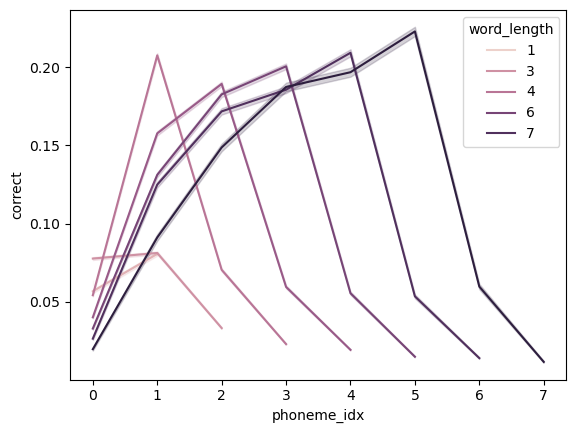

In [142]:
sns.lineplot(data=test_df_fwd[test_df_fwd.word_length <= 8], x="phoneme_idx", y="correct", hue="word_length",
             errorbar="se")

### Backward bigram

In [170]:
dec_bwd_2 = NgramDecoder(lst, device)
dec_bwd_2.prepare_dataset(frame_metadata, "backward_bigram")

Number of classes: 637


/userdata/jgauthier/projects/ideal-word-representations/src/analysis/ngram_decoding.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame_metadata["class_idx"] = self.frame_metadata[class_key].map(self.class_to_idx)
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/ngram_decoding.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame_metadata["class_idx"] = self.frame_metadata[class_key].map(self.class_to_idx)
/userdata/jgauthier/projects/ideal-word-representations/src/

In [171]:
dec_bwd_2.prime()

In [172]:
dec_bwd_2.train()

Iteration 0, Training Loss: 6.4794230461120605


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 0, Validation Loss: 6.458297397151138
Iteration 500, Training Loss: 4.609435081481934


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 500, Validation Loss: 4.617860418377501
Iteration 1000, Training Loss: 3.728483200073242


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 1000, Validation Loss: 3.935557900053082
Iteration 1500, Training Loss: 3.522338628768921


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 1500, Validation Loss: 3.596571604410807
Iteration 2000, Training Loss: 3.0665786266326904


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 2000, Validation Loss: 3.4005546858816436
Iteration 2500, Training Loss: 3.231761932373047


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 2500, Validation Loss: 3.270089424017704
Iteration 3000, Training Loss: 3.346092700958252


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 3000, Validation Loss: 3.1851629199403706
Iteration 3500, Training Loss: 3.139620304107666


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 3500, Validation Loss: 3.1201588746273154
Iteration 4000, Training Loss: 3.240135669708252


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 4000, Validation Loss: 3.071655598553744
Iteration 4500, Training Loss: 2.9609506130218506


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 4500, Validation Loss: 3.035983526345455
Iteration 5000, Training Loss: 2.871220588684082


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 5000, Validation Loss: 3.0080464030757095
Iteration 5500, Training Loss: 2.9665706157684326


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 5500, Validation Loss: 2.981306776855931
Iteration 6000, Training Loss: 2.529914140701294


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 6000, Validation Loss: 2.959772637396148
Iteration 6500, Training Loss: 2.766695261001587


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 6500, Validation Loss: 2.943677540981408
Iteration 7000, Training Loss: 2.724184989929199


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 7000, Validation Loss: 2.932244394764756
Iteration 7500, Training Loss: 2.796583414077759


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 7500, Validation Loss: 2.9176962086648652
Iteration 8000, Training Loss: 2.9832537174224854


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 8000, Validation Loss: 2.907563809192542
Iteration 8500, Training Loss: 3.3969647884368896


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 8500, Validation Loss: 2.898220322348855
Iteration 9000, Training Loss: 2.9102237224578857


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 9000, Validation Loss: 2.8929087031971323
Iteration 9500, Training Loss: 2.9961109161376953


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 9500, Validation Loss: 2.8823080640850645
Iteration 10000, Training Loss: 2.8152480125427246


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 10000, Validation Loss: 2.875834154360222
Iteration 10500, Training Loss: 3.1239452362060547


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 10500, Validation Loss: 2.869085571982644
Iteration 11000, Training Loss: 2.9064929485321045


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 11000, Validation Loss: 2.8651970733295786
Iteration 11500, Training Loss: 3.1117067337036133


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 11500, Validation Loss: 2.8636790839108555
Iteration 12000, Training Loss: 2.82123064994812


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 12000, Validation Loss: 2.857279329588919
Iteration 12500, Training Loss: 2.560555934906006


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 12500, Validation Loss: 2.8507696715268223
Iteration 13000, Training Loss: 2.5557172298431396


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 13000, Validation Loss: 2.8511719053441826
Iteration 13500, Training Loss: 2.529465675354004


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 13500, Validation Loss: 2.8483664483735054
Iteration 14000, Training Loss: 3.0584428310394287


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 14000, Validation Loss: 2.844022071722782
Iteration 14500, Training Loss: 3.3278496265411377


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 14500, Validation Loss: 2.844822240598274
Iteration 15000, Training Loss: 2.721151113510132


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 15000, Validation Loss: 2.840073657758308
Iteration 15500, Training Loss: 3.206721782684326


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 15500, Validation Loss: 2.8394266692074863
Iteration 16000, Training Loss: 3.3197803497314453


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 16000, Validation Loss: 2.8381806286898525
Iteration 16500, Training Loss: 2.5276687145233154


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 16500, Validation Loss: 2.83627936334321
Iteration 17000, Training Loss: 2.4110360145568848


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 17000, Validation Loss: 2.8315126317920107
Iteration 17500, Training Loss: 2.677316188812256


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 17500, Validation Loss: 2.8308963775634766
Iteration 18000, Training Loss: 3.473071813583374


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 18000, Validation Loss: 2.8299287882718174
Iteration 18500, Training Loss: 3.4622457027435303


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 18500, Validation Loss: 2.82710405552026
Iteration 19000, Training Loss: 2.401503801345825


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 19000, Validation Loss: 2.828657692128962
Iteration 19500, Training Loss: 2.883010149002075


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 19500, Validation Loss: 2.8239676591121787
Iteration 20000, Training Loss: 2.5265753269195557


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 20000, Validation Loss: 2.8262566725413003
Iteration 20500, Training Loss: 2.5304038524627686


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 20500, Validation Loss: 2.821617921193441
Iteration 21000, Training Loss: 2.8081307411193848


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 21000, Validation Loss: 2.8188341025150185
Iteration 21500, Training Loss: 3.077197790145874


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 21500, Validation Loss: 2.821758862697717
Iteration 22000, Training Loss: 2.7217254638671875


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 22000, Validation Loss: 2.818583849704627
Iteration 22500, Training Loss: 2.720538377761841


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 22500, Validation Loss: 2.8171986016360195
Iteration 23000, Training Loss: 3.2204198837280273


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 23000, Validation Loss: 2.8170661492781206
Iteration 23500, Training Loss: 3.2662699222564697


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 23500, Validation Loss: 2.8160974979400635
Iteration 24000, Training Loss: 2.804072856903076


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 24000, Validation Loss: 2.8148810718998765
Iteration 24500, Training Loss: 2.831299066543579


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 24500, Validation Loss: 2.8183715704715615
Iteration 25000, Training Loss: 2.868025302886963


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 25000, Validation Loss: 2.8159051736195884
Iteration 25500, Training Loss: 3.023435115814209


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 25500, Validation Loss: 2.8142483378901626
Iteration 26000, Training Loss: 2.767956018447876


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 26000, Validation Loss: 2.8177217642466226
Iteration 26500, Training Loss: 3.1782476902008057


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 26500, Validation Loss: 2.8174838080550684
Iteration 27000, Training Loss: 2.53085994720459


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 27000, Validation Loss: 2.8139555887742476
Iteration 27500, Training Loss: 2.6568455696105957


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 27500, Validation Loss: 2.8157815644235322
Iteration 28000, Training Loss: 2.562554121017456


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 28000, Validation Loss: 2.812124252319336
Iteration 28500, Training Loss: 2.6761975288391113


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 28500, Validation Loss: 2.810682166706432
Iteration 29000, Training Loss: 2.254568338394165


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 29000, Validation Loss: 2.810306527397849
Iteration 29500, Training Loss: 2.630204200744629


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 29500, Validation Loss: 2.810819792025017
Iteration 30000, Training Loss: 2.490084648132324


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 30000, Validation Loss: 2.8083793394493335
Iteration 30500, Training Loss: 2.746037006378174


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 30500, Validation Loss: 2.806717569177801
Iteration 31000, Training Loss: 2.5477538108825684


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 31000, Validation Loss: 2.807165543238322
Iteration 31500, Training Loss: 2.844860315322876


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 31500, Validation Loss: 2.8114973776268237
Iteration 32000, Training Loss: 2.6857798099517822


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration 32000, Validation Loss: 2.809789296352502
Early stopping


In [173]:
test_df_bwd_2 = dec_bwd_2.predict()
test_df_bwd_2 = pd.merge(test_df_bwd_2,
                   (test_df_bwd_2.groupby(["label", "instance_idx"]).phoneme_idx.max() + 1).rename("word_length"),
                   left_on=["label", "instance_idx"],
                   right_index=True)

Testing:   0%|          | 0/1058 [00:00<?, ?it/s]

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

<Axes: xlabel='phoneme_idx', ylabel='correct'>

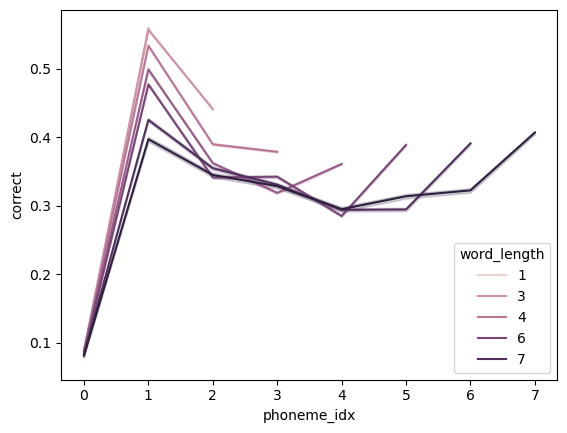

In [174]:
sns.lineplot(data=test_df_bwd_2[test_df_bwd_2.word_length <= 8], x="phoneme_idx", y="correct", hue="word_length",
             errorbar="se")